# 3.morphogenesis features

## Packages

In [1]:
import os
import sys

import gseapy as gp
import numpy as np
import dynamo as dyn
import spateo as st

/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and poin

## Data source

In [2]:
# The anndata object is reconstructed by ``2.morphogenesis vector fields and trajectories``
stage_adata = st.drosophila(url="https://www.dropbox.com/s/cz2nqpmoc3oo5f3/E7-9h_cellbin_tdr_v3_midgut.h5ad?dl=0")
stage_adata = stage_adata[:, np.sum(stage_adata.layers["counts_X"], axis=0) != 0]
stage_adata.X = stage_adata.layers["counts_X"].copy()
stage_adata.uns["pp"] = {}
dyn.pp.normalize_cell_expr_by_size_factors(adata=stage_adata, layers="X", X_total_layers=True,  skip_log=True)

# The pc model and mesh model are reconstructed by ``2.morphogenesis vector fields and trajectories``
stage_pc = st.tdr.read_model(f"vector_pc_model_midgut.vtk")
stage_mesh = st.tdr.read_model(f"vector_mesh_model_midgut.vtk")

cpo = [(531.4285063139628 / 1.5, 1120.6071331378873 / 1.5, 226.6879332984771 / 1.5),
 (1.9670869138005287, -6.902875264241757, -2.2120172004343885),
 (-0.1349909265808914, -0.13586573883518835, 0.9814876212931068)]

stage_adata

|-----> rounding expression data of layer: X during size factor calculation
|-----> size factor normalize following layers: ['X']
|-----? `total_szfactor` is not `None` and it is not in adata object.
|-----> skipping log transformation as input requires...
|-----> applying None to layer<X>
|-----> set adata <X> to normalized data.
|-----> <insert> pp.norm_method to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2326 × 7685
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size'
    uns: 'PCs', 'VecFld_morpho', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'fate_morpho', 'latter_models_align', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'pp', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial'
    obsm: '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'align_spatial', 'bbox', 'before_3d_align_spatial', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial'
    layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced'

## Generate the trajectory model

In [3]:
trajectory_model = st.tdr.construct_trajectory(
        adata=stage_adata,
        fate_key="fate_morpho",
        key_added="obs_index",
        n_sampling=500,
        sampling_method="trn",
        label=np.asarray(stage_adata.obs.index),
        )

|-----> [Running TRN] in progress: 100.0000%
|-----> [Running TRN] finished [23.7339s]


## Morphogenesis features

In [5]:
glm_dict = {}

### Velocity

In [6]:
key = "velocity"
st.tdr.morphofield_velocity(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
stage_adata.obsm["velocity"]

array([[-1.91148383e-03, -1.82671905e-03, -2.71598635e-03],
       [-1.95678207e-03, -1.91036185e-03, -2.87477111e-03],
       [-1.55106979e-03, -1.68945969e-03, -2.41216961e-03],
       ...,
       [-2.10651796e-06,  1.09092371e-04,  1.71498103e-03],
       [ 1.89100976e-06,  8.49589979e-05,  1.72119623e-03],
       [-8.09060396e-05,  1.64108170e-04,  1.67981541e-03]])

### Acceleration

In [7]:
key = "acceleration"
glm_key = f"glm_degs_{key}"
st.tdr.morphofield_acceleration(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
st.tl.glm_degs(adata=stage_adata, layer=None, fullModelFormulaStr=f'~cr({key}, df=3)', key_added=glm_key, qval_threshold=0.01, llf_threshold=-2500)
glm_data = stage_adata.uns[glm_key]["glm_result"]
glm_dict[key] = glm_data
glm_data

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.0412s]
|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [375.0744s]


status family  log-likelihood          pval          qval
Bacc                    ok    NB2    -3671.859375  4.873121e-11  7.489986e-09
28SrRNA-Psi:CR45862     ok    NB2    -4358.506348  6.277172e-10  6.432008e-08
Cys                     ok    NB2    -4643.826172  4.387060e-08  2.148794e-06
28SrRNA-Psi:CR45859     ok    NB2    -4632.636230  2.513353e-06  4.769165e-05
eEF1beta                ok    NB2    -3303.432861  1.365682e-05  1.904767e-04
Nph                     ok    NB2    -3012.880371  3.456467e-05  3.855290e-04
fax                     ok    NB2    -2740.145508  5.348858e-05  5.373330e-04
His3.3A                 ok    NB2    -3064.583496  6.052202e-05  5.887490e-04
Fib                     ok    NB2    -2566.735840  2.022182e-04  1.532591e-03
awd                     ok    NB2    -3193.938477  6.848338e-04  3.859636e-03
mt:lrRNA                ok    NB2    -6083.094238  7.883165e-04  4.318041e-03
tsr                     ok    NB2    -3093.676758  9.017585e-04  4.782618e-03
28SrRNA-Psi:CR40596     ok    NB2    -3915.597412  1.051448e-03  5.379748e-03
pAbp                    ok    NB2    -3751.640137  1.692311e-03  7.820453e-03

Saving figure to develop/develop_midgut/genesis_feature/E7-9h_midgut_acceleration/E7-9h_midgut_glm_degs_fit_acceleration.pdf...
Done


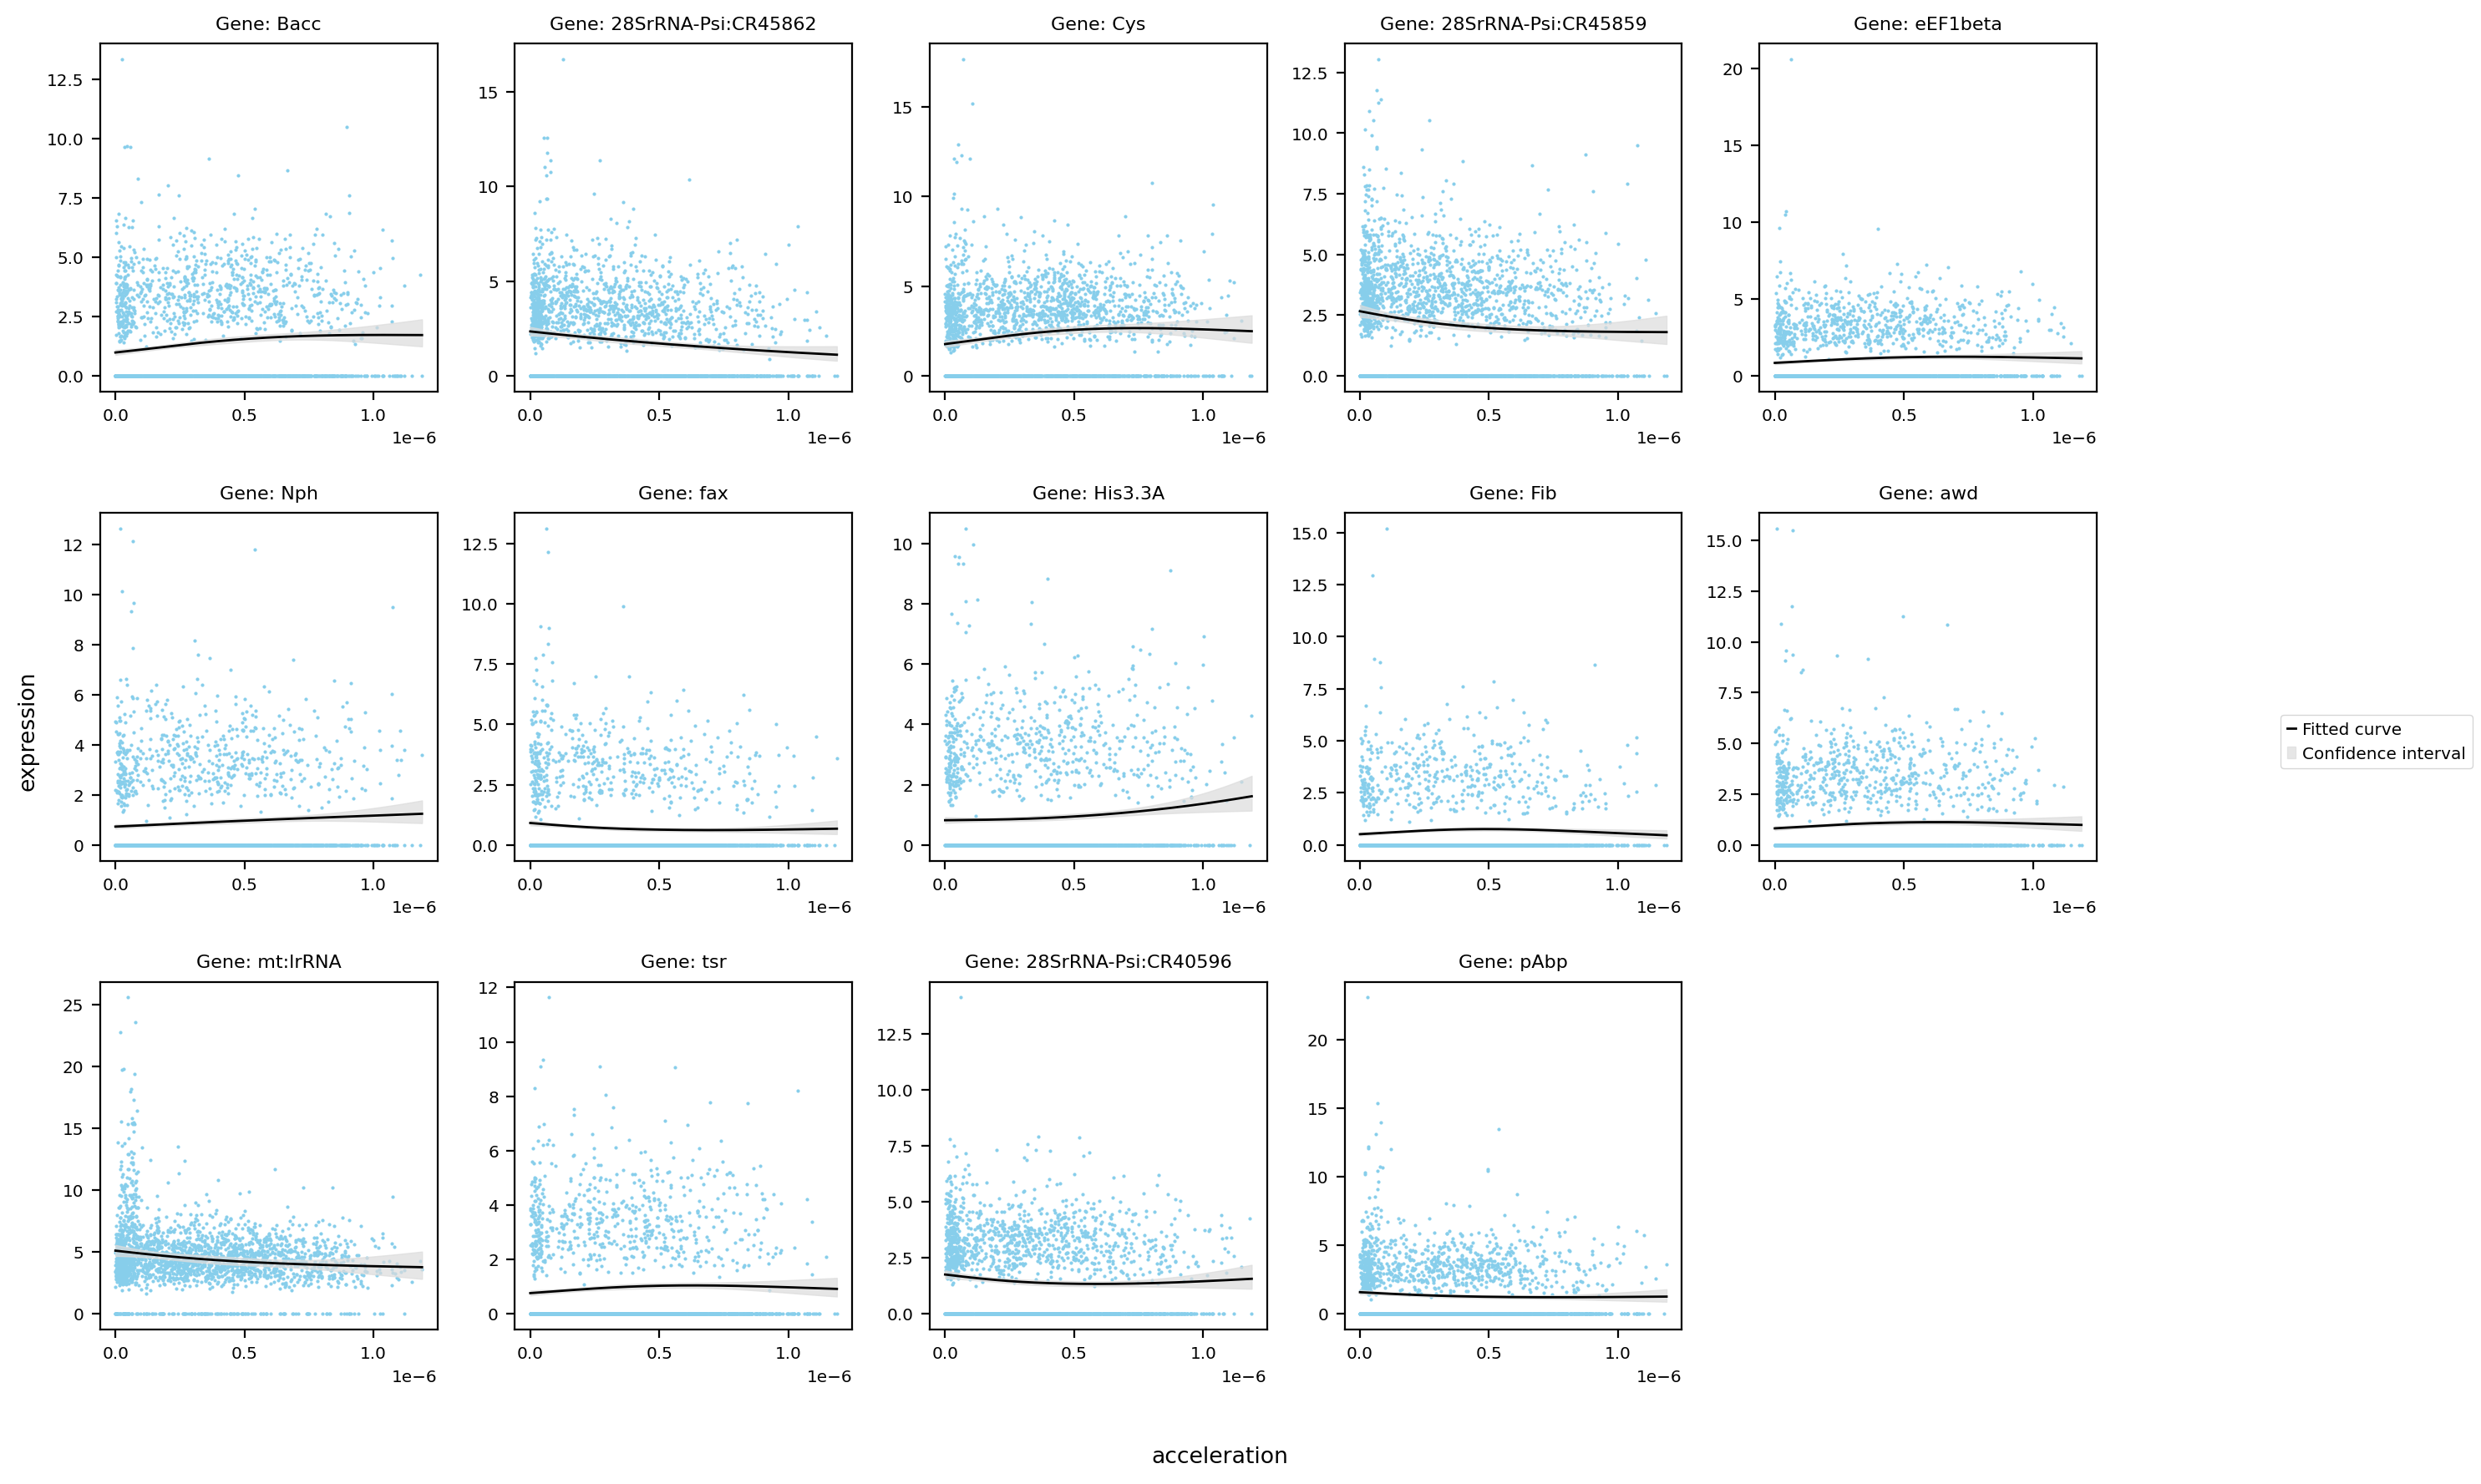

Saving figure to develop/develop_midgut/genesis_feature/E7-9h_midgut_acceleration/E7-9h_midgut_glm_degs_fit_acceleration_lowess.pdf...
Done


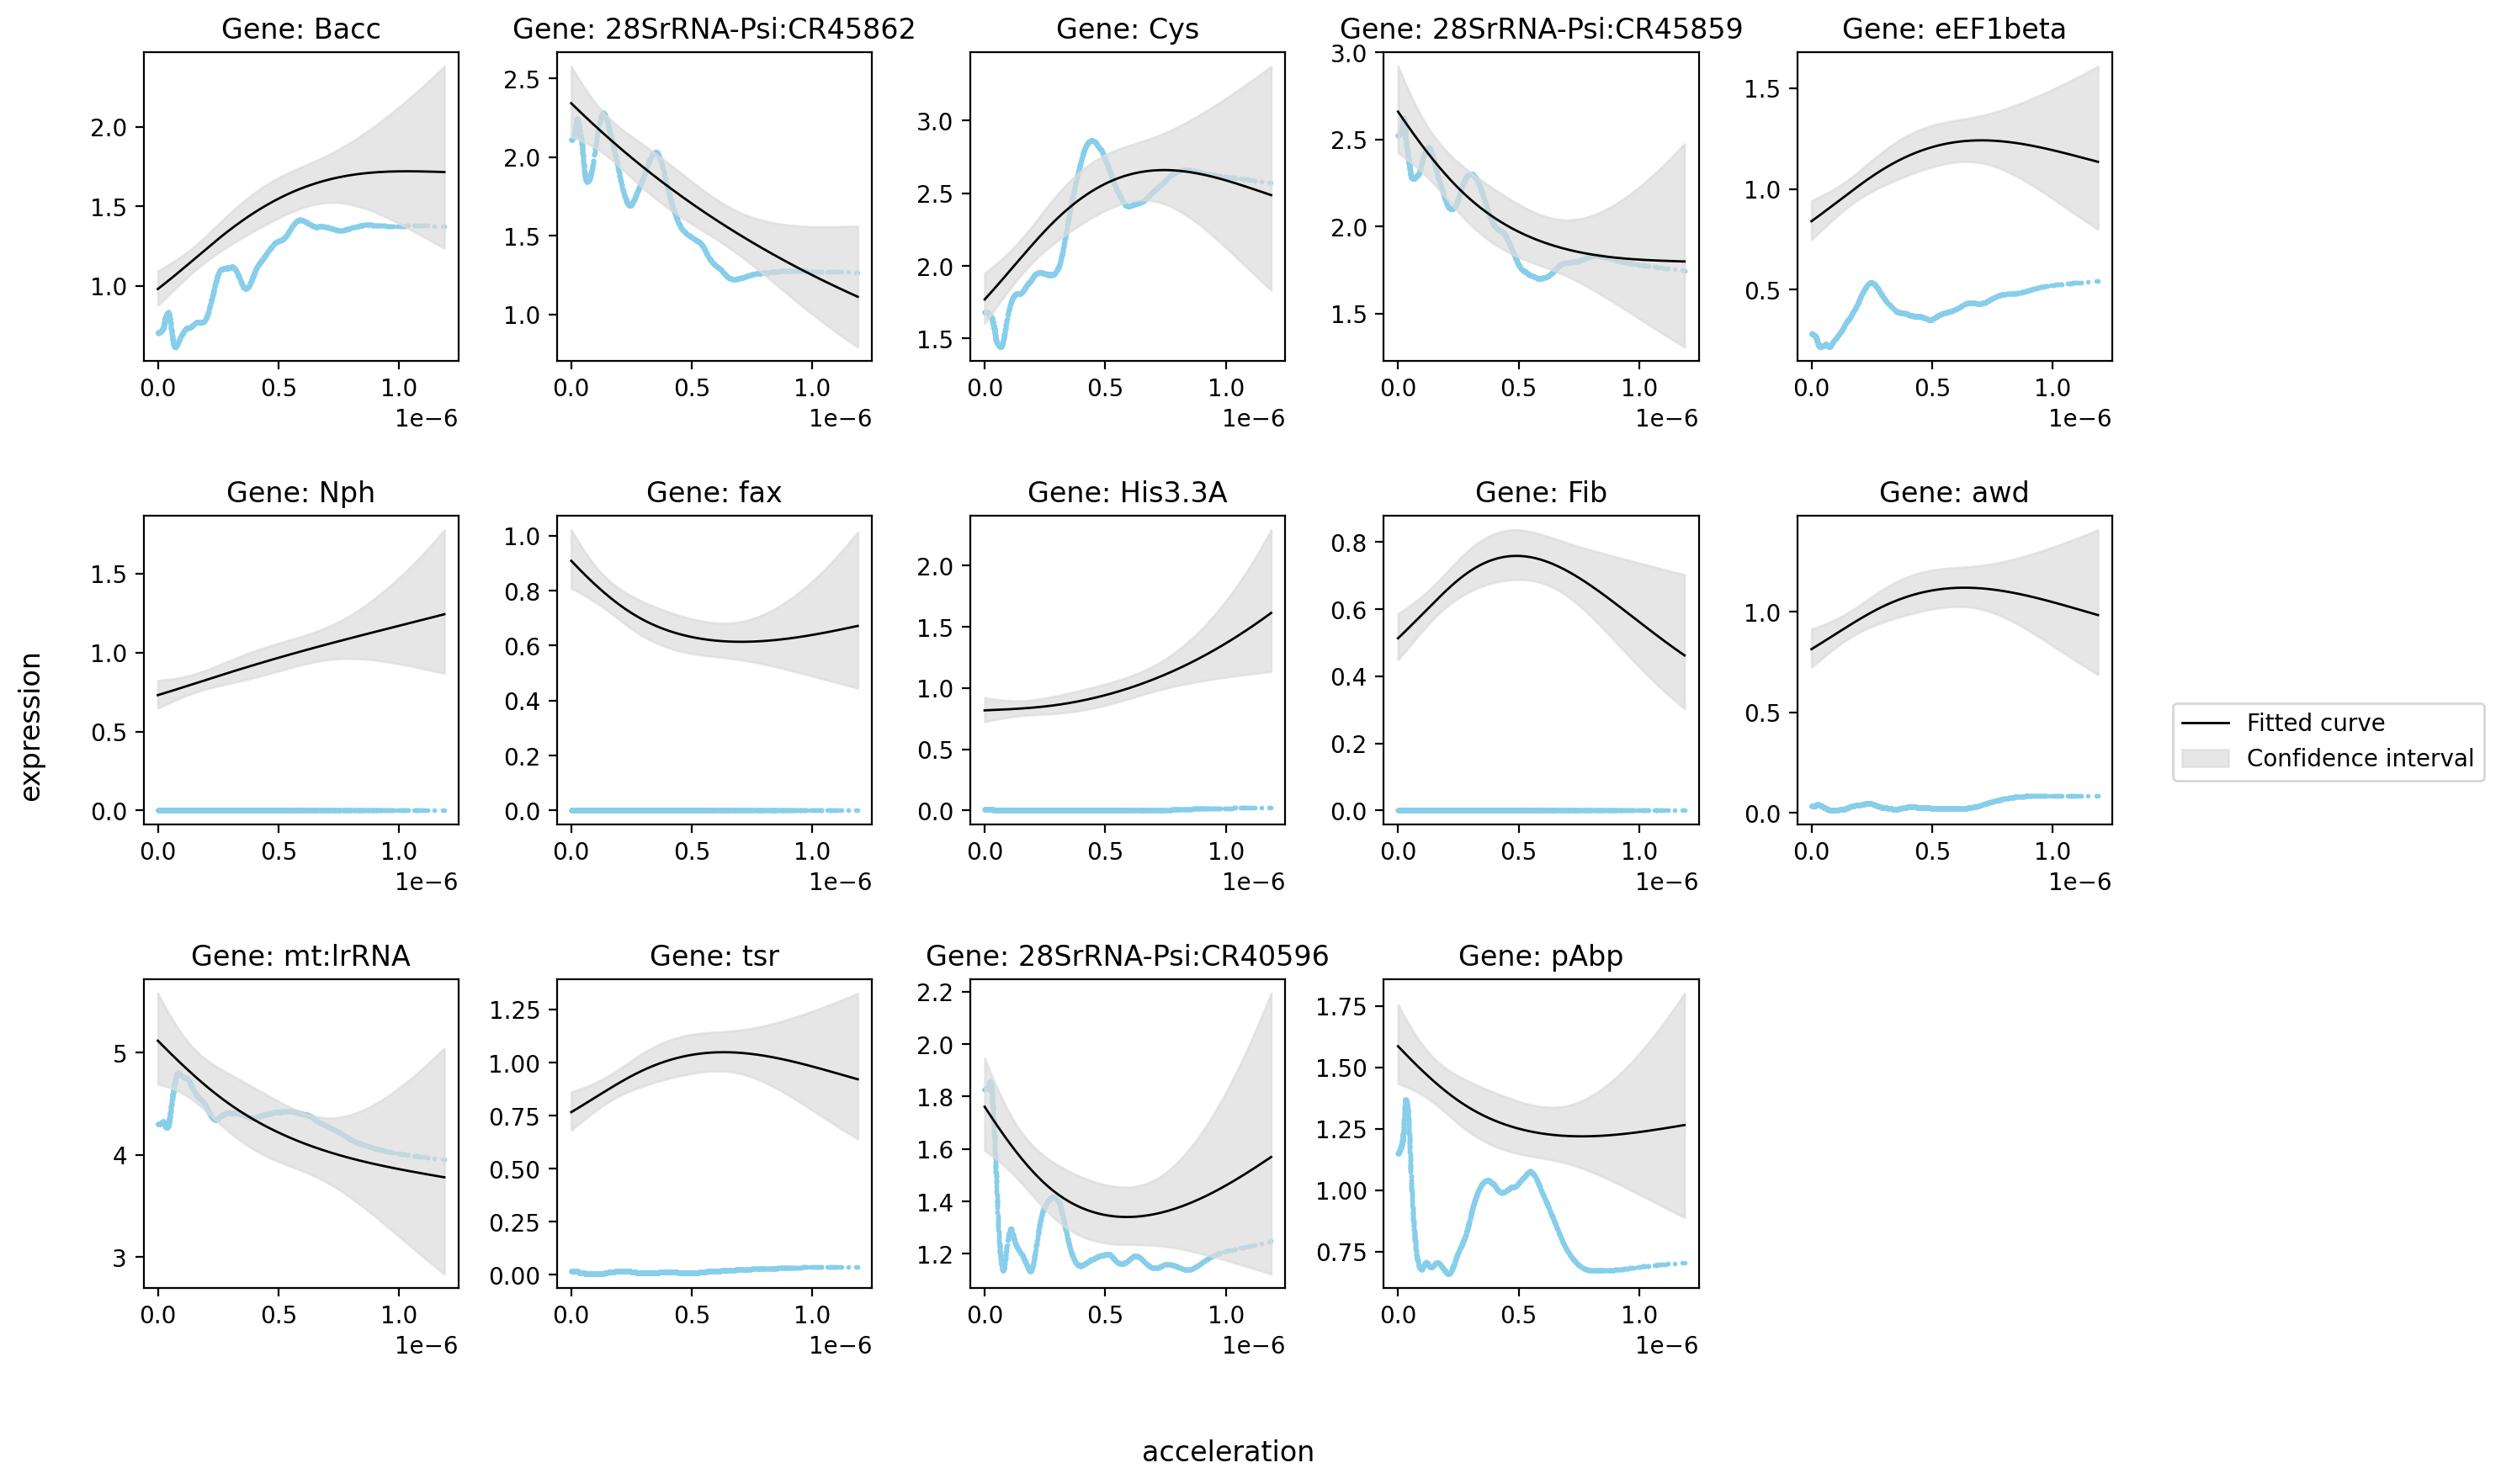

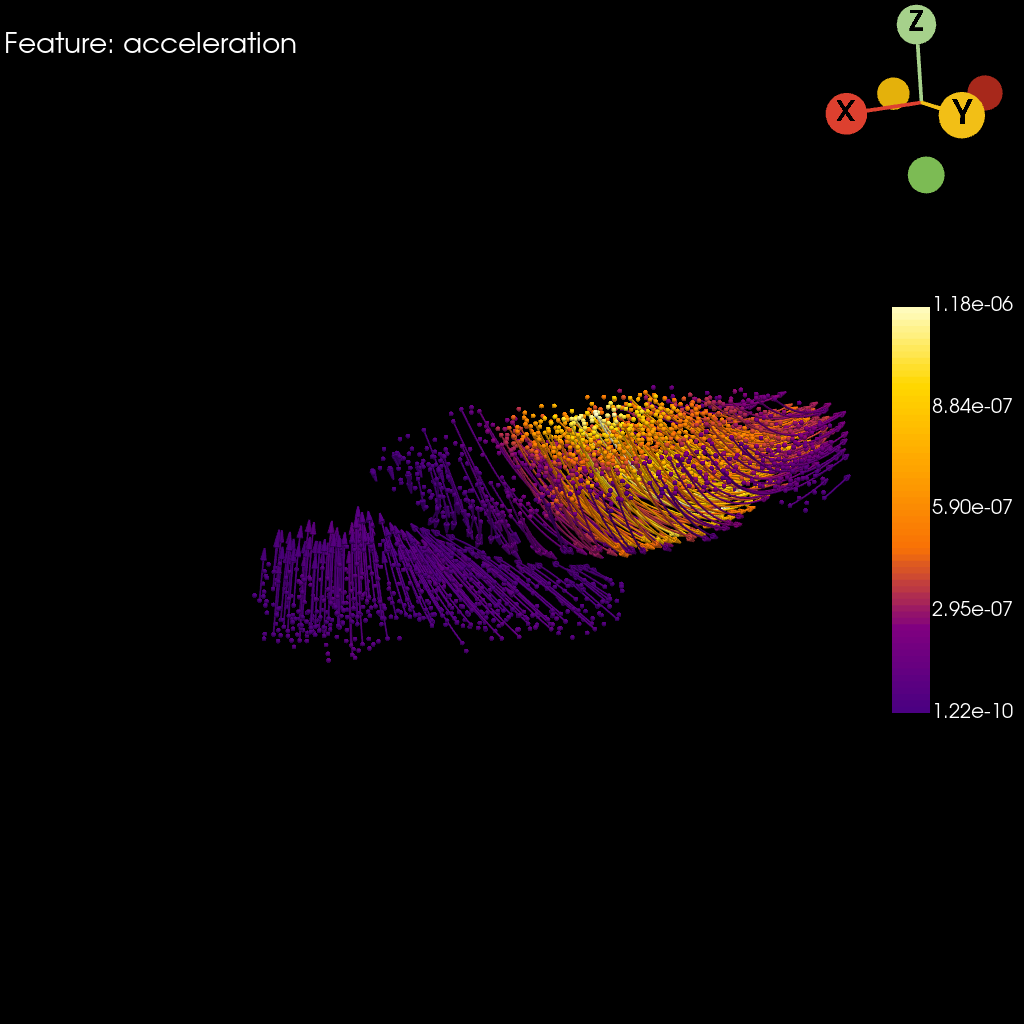

In [8]:
st.pl.glm_fit(
    adata=stage_adata,
    gene=glm_data.index.tolist(),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    lowess=False,
    frac=0.2,
    save_show_or_return="all",
)
st.pl.glm_fit(
    adata=stage_adata,
    gene=glm_data.index.tolist(),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    lowess=True,
    frac=0.2,
    save_show_or_return="all",
)
st.pl.acceleration(
    adata=stage_adata,
    model=st.tdr.collect_models([stage_pc, trajectory_model]),
    acceleration_key=key,
    colormap="default_cmap",
    jupyter="static",
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    cpo=cpo,
    window_size=(1024, 1024),
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
)

In [9]:
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added=key,
    labels=np.asarray(stage_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[key]),
    where="point_data",
    inplace=True,
)
cells_linear_models = st.tdr.construct_genesis_X(
    stages_X=[stage_adata.obsm["3d_align_spatial"], stage_adata.obsm["X_cells_mapping"]],
    n_spacing=100-1,
    key_added=key,
    label=[np.asarray(stage_adata.obs[key])] * 100,
)
st.pl.three_d_animate(
     models=cells_linear_models,
    stable_model=trajectory_model,
    key=key,
    stable_kwargs=dict(
        key=key,
        model_style="wireframe",
        model_size=2,
        ambient=0.5,
        opacity=0.3,
        colormap="default_cmap",
        show_legend=False,
    ),
    filename=f"E7-9h_midgut_{key}_linear_movie_with_trajectory.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)
st.pl.three_d_animate(
    models=cells_linear_models,
    stable_model=None,
    key=key,
    filename=f"E7-9h_midgut_{key}_linear_movie.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)

### Curvature

In [10]:
key = "curvature"
glm_key = f"glm_degs_{key}"

st.tdr.morphofield_curvature(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
st.tl.glm_degs(adata=stage_adata, layer=None, fullModelFormulaStr=f'~cr({key}, df=3)', key_added=glm_key, qval_threshold=0.01, llf_threshold=-2500)
glm_data = stage_adata.uns[glm_key]["glm_result"]
glm_dict[key] = glm_data
glm_data

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.0304s]
|-----> [Calculating curvature] in progress: 100.0000%
|-----> [Calculating curvature] finished [0.0381s]
|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [287.0102s]


status family  log-likelihood          pval          qval
Ance                    ok    NB2    -3339.842529  5.916981e-13  1.136800e-09
Fib                     ok    NB2    -2560.309814  3.273910e-07  8.064102e-06
28SrRNA-Psi:CR40596     ok    NB2    -3911.105713  1.177748e-05  1.544538e-04
mt:ND5                  ok    NB2    -2526.593506  2.593650e-05  2.823258e-04
RpL24-like              ok    NB2    -3122.291748  2.842352e-05  3.025412e-04
Cys                     ok    NB2    -4650.455078  3.319294e-05  3.410264e-04
28SrRNA-Psi:CR45862     ok    NB2    -4370.237793  7.809990e-05  6.751381e-04
RNASEK                  ok    NB2    -2597.170898  1.023775e-04  8.238442e-04
His2Av                  ok    NB2    -3063.656494  1.208075e-04  9.377835e-04
sesB                    ok    NB2    -2753.985596  1.806184e-04  1.286111e-03
COX7C                   ok    NB2    -2909.798096  3.349247e-04  2.114103e-03
Obp99a                  ok    NB2    -3229.527588  4.188366e-04  2.513024e-03
Cyp1                    ok    NB2    -3645.378418  8.155234e-04  4.231801e-03
chic                    ok    NB2    -2536.232910  8.432105e-04  4.340303e-03
RpS16                   ok    NB2    -4785.575684  1.652613e-03  7.349729e-03

Saving figure to develop/develop_midgut/genesis_feature/E7-9h_midgut_curvature/E7-9h_midgut_glm_degs_fit_curvature.pdf...
Done


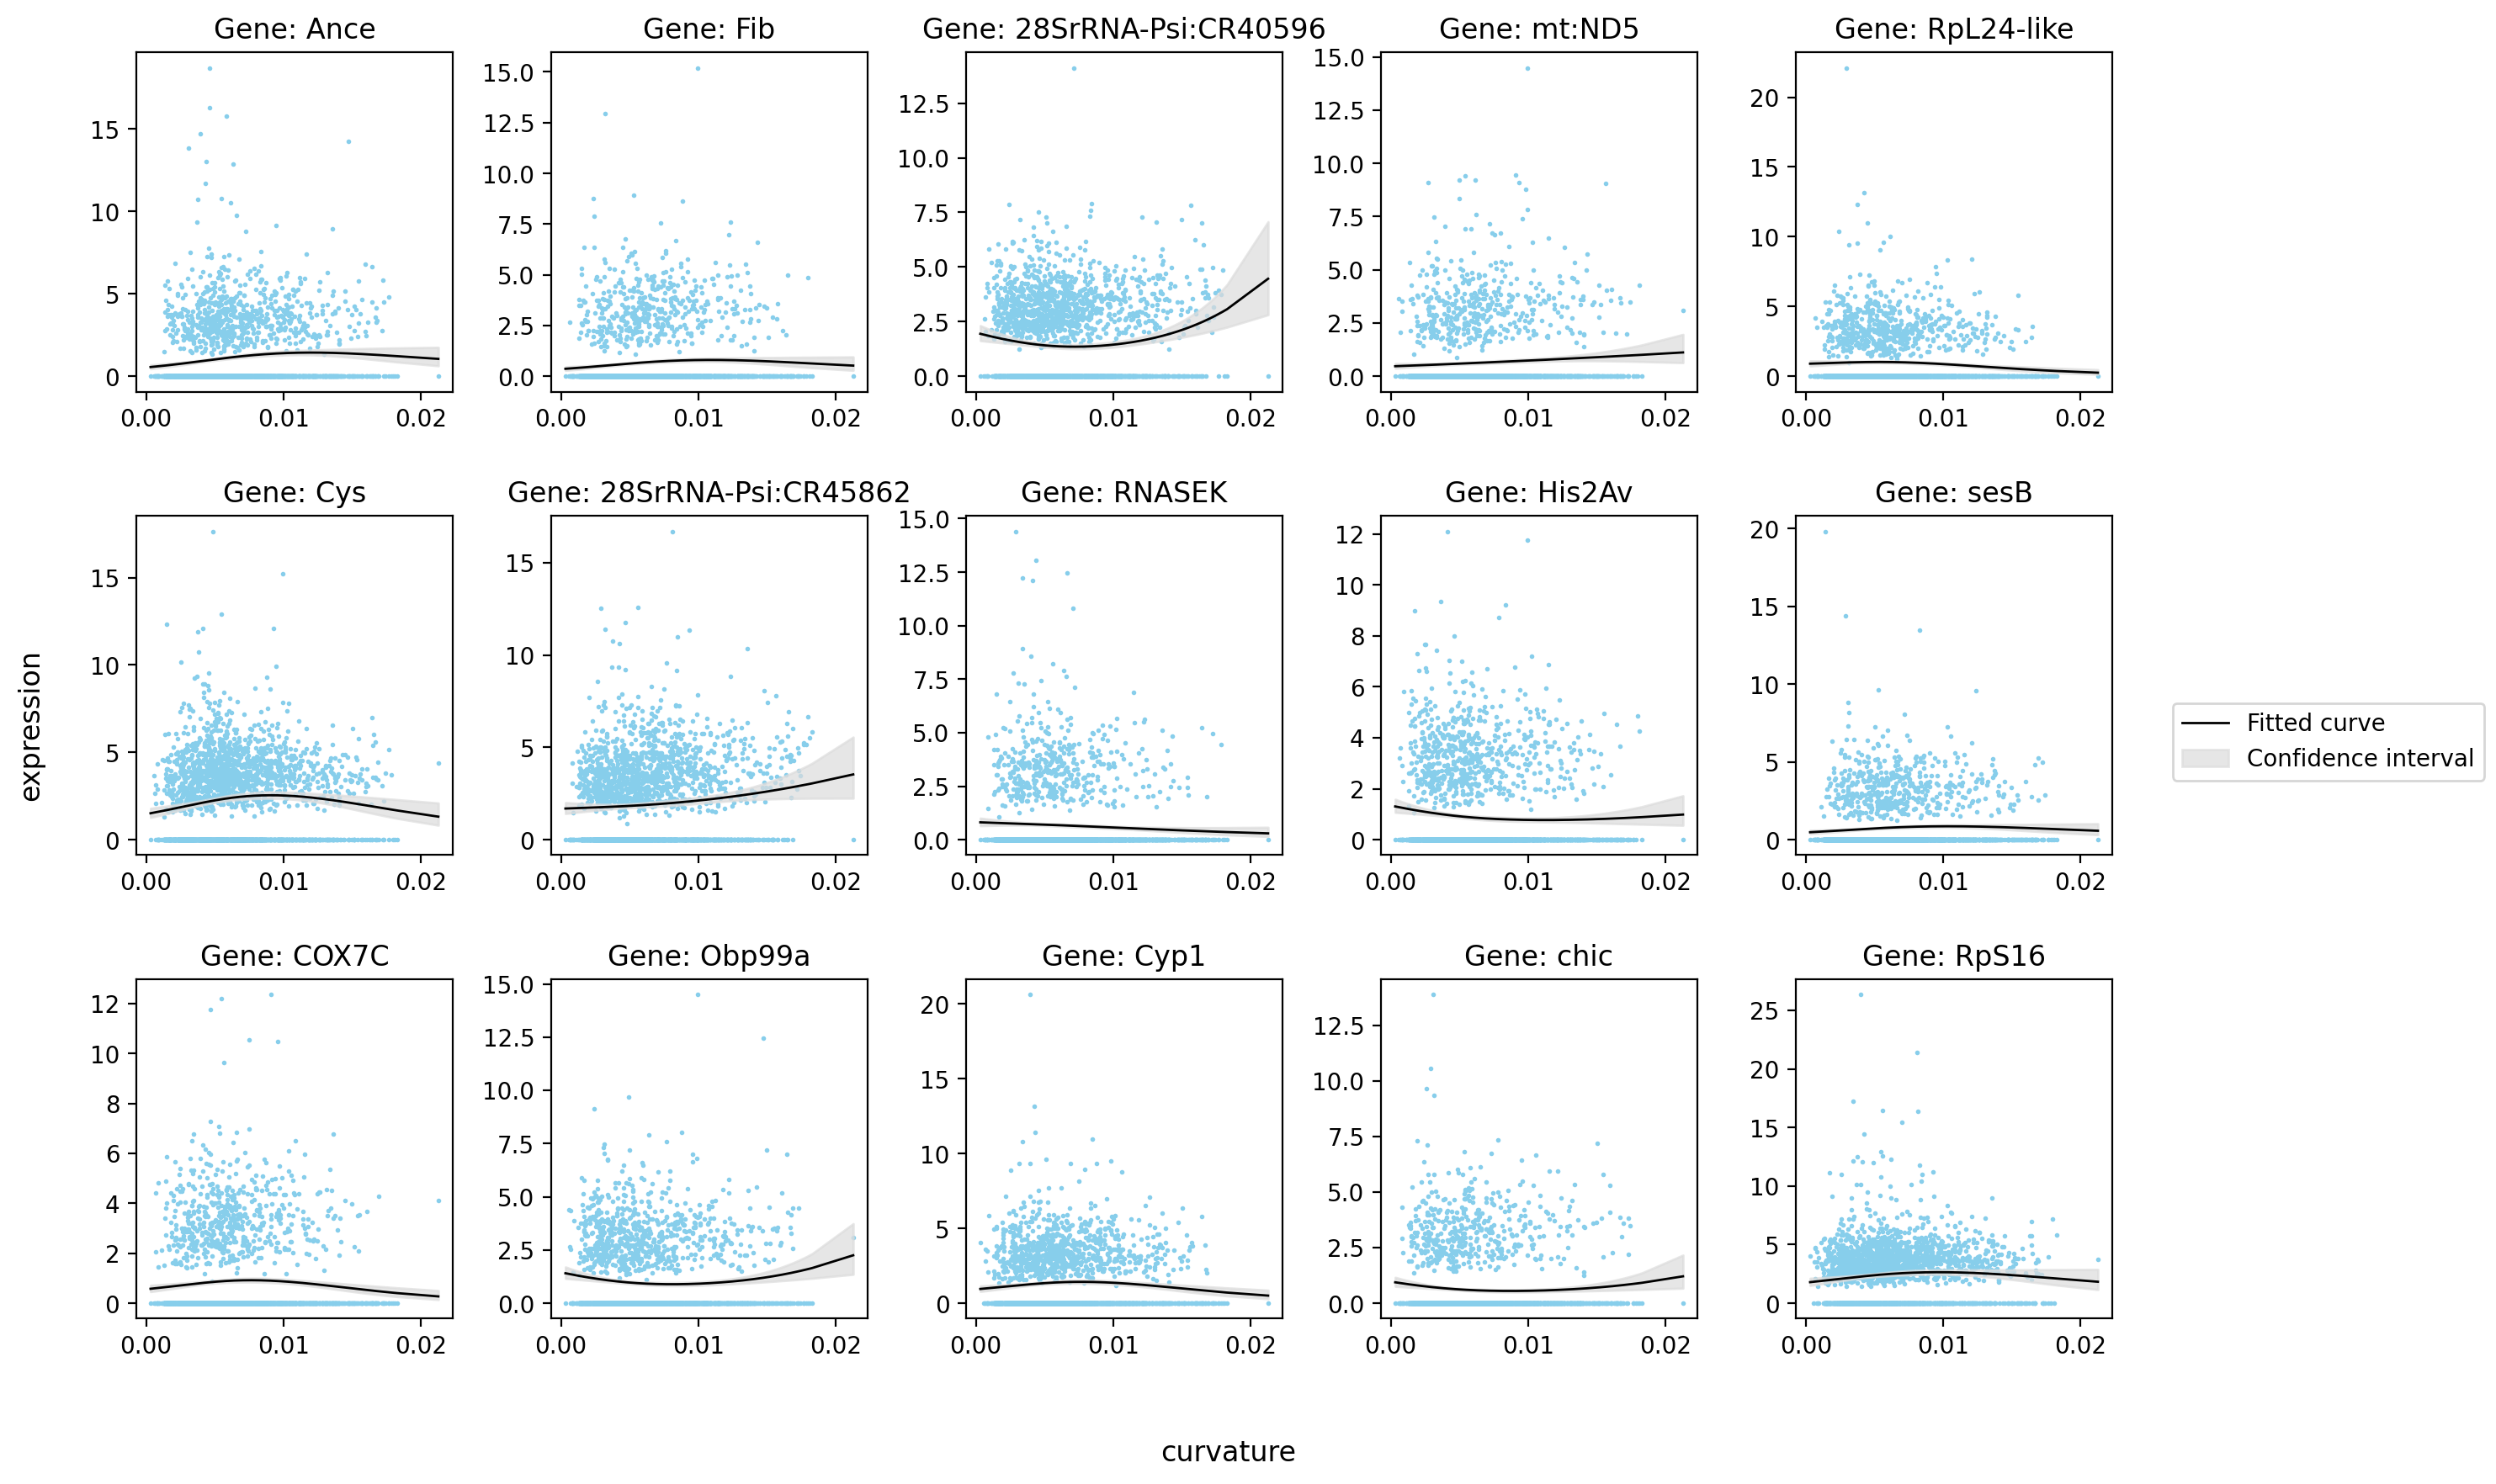

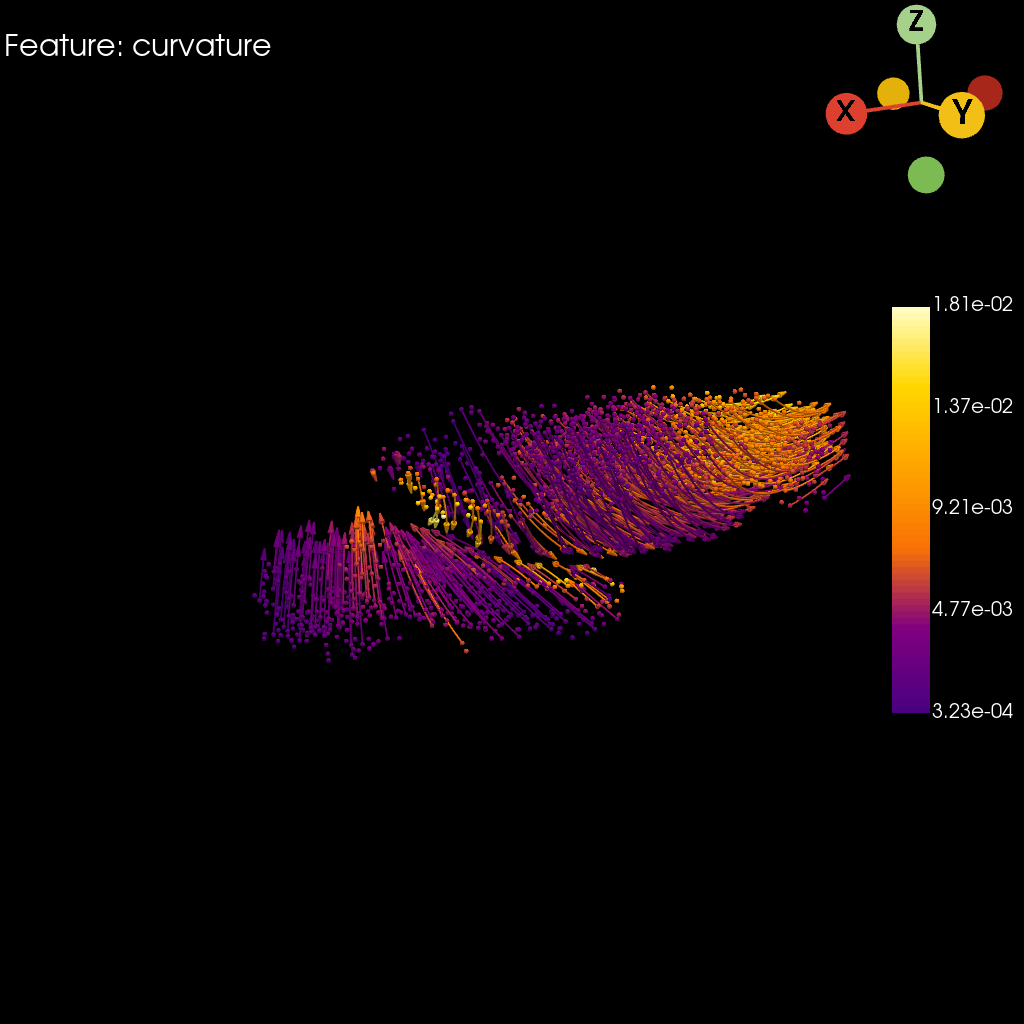

In [11]:
st.pl.glm_fit(
    adata=stage_adata,
    gene=glm_data.index.tolist(),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    lowess=False,
    frac=0.2,
    save_show_or_return="both",
)
st.pl.curvature(
    adata=stage_adata,
    model=st.tdr.collect_models([stage_pc, trajectory_model]),
    curvature_key=key,
    colormap="default_cmap",
    jupyter="static",
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    cpo=cpo,
    window_size=(1024, 1024),
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20)
)

In [12]:
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added=key,
    labels=np.asarray(stage_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[key]),
    where="point_data",
    inplace=True,
)
cells_linear_models = st.tdr.construct_genesis_X(
    stages_X=[stage_adata.obsm["3d_align_spatial"], stage_adata.obsm["X_cells_mapping"]],
    n_spacing=100-1,
    key_added=key,
    label=[np.asarray(stage_adata.obs[key])] * 100,
)
st.pl.three_d_animate(
     models=cells_linear_models,
    stable_model=trajectory_model,
    key=key,
    stable_kwargs=dict(
        key=key,
        model_style="wireframe",
        model_size=2,
        ambient=0.5,
        opacity=0.3,
        colormap="default_cmap",
        show_legend=False,
    ),
    filename=f"E7-9h_midgut_{key}_linear_movie_with_trajectory.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)
st.pl.three_d_animate(
    models=cells_linear_models,
    stable_model=None,
    key=key,
    filename=f"E7-9h_midgut_{key}_linear_movie.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)

### Curl

In [13]:
key = "curl"
glm_key = f"glm_degs_{key}"

st.tdr.morphofield_curl(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
st.tl.glm_degs(adata=stage_adata, layer=None, fullModelFormulaStr=f'~cr({key}, df=3)', key_added=glm_key, qval_threshold=0.01, llf_threshold=-2500)
glm_data = stage_adata.uns[glm_key]["glm_result"]
glm_dict[key] = glm_data
glm_data

Calculating 3-D curl: 100%|██████████| 2326/2326 [00:00<00:00, 57530.08it/s]

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.


|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [267.5932s]


status family  log-likelihood          pval      qval
Fib                     ok    NB2    -2560.906738  5.947219e-07  0.000015
pAbp                    ok    NB2    -3744.795410  1.802494e-06  0.000038
COX8                    ok    NB2    -3233.309570  2.275150e-05  0.000267
28SrRNA-Psi:CR40596     ok    NB2    -3912.000488  2.882065e-05  0.000321
Ance                    ok    NB2    -3358.986572  1.219921e-04  0.001011
tsr                     ok    NB2    -3092.293213  2.260249e-04  0.001625
Nph                     ok    NB2    -3015.566162  5.069769e-04  0.003041
RpL24-like              ok    NB2    -3125.715576  8.723374e-04  0.004005
Bacc                    ok    NB2    -3688.385254  7.326030e-04  0.004059
28SrRNA-Psi:CR45859     ok    NB2    -4638.458984  8.491511e-04  0.004522
fax                     ok    NB2    -2743.038330  9.650021e-04  0.005024
NHP2                    ok    NB2    -2605.645508  1.179141e-03  0.005976
CNBP                    ok    NB2    -3570.270264  1.538176e-03  0.006671
ATPsynG                 ok    NB2    -3090.621582  1.784211e-03  0.008645
mt:ND1                  ok    NB2    -3178.442871  2.424773e-03  0.009808

Saving figure to develop/develop_midgut/genesis_feature/E7-9h_midgut_curl/E7-9h_midgut_glm_degs_fit_curl.pdf...
Done


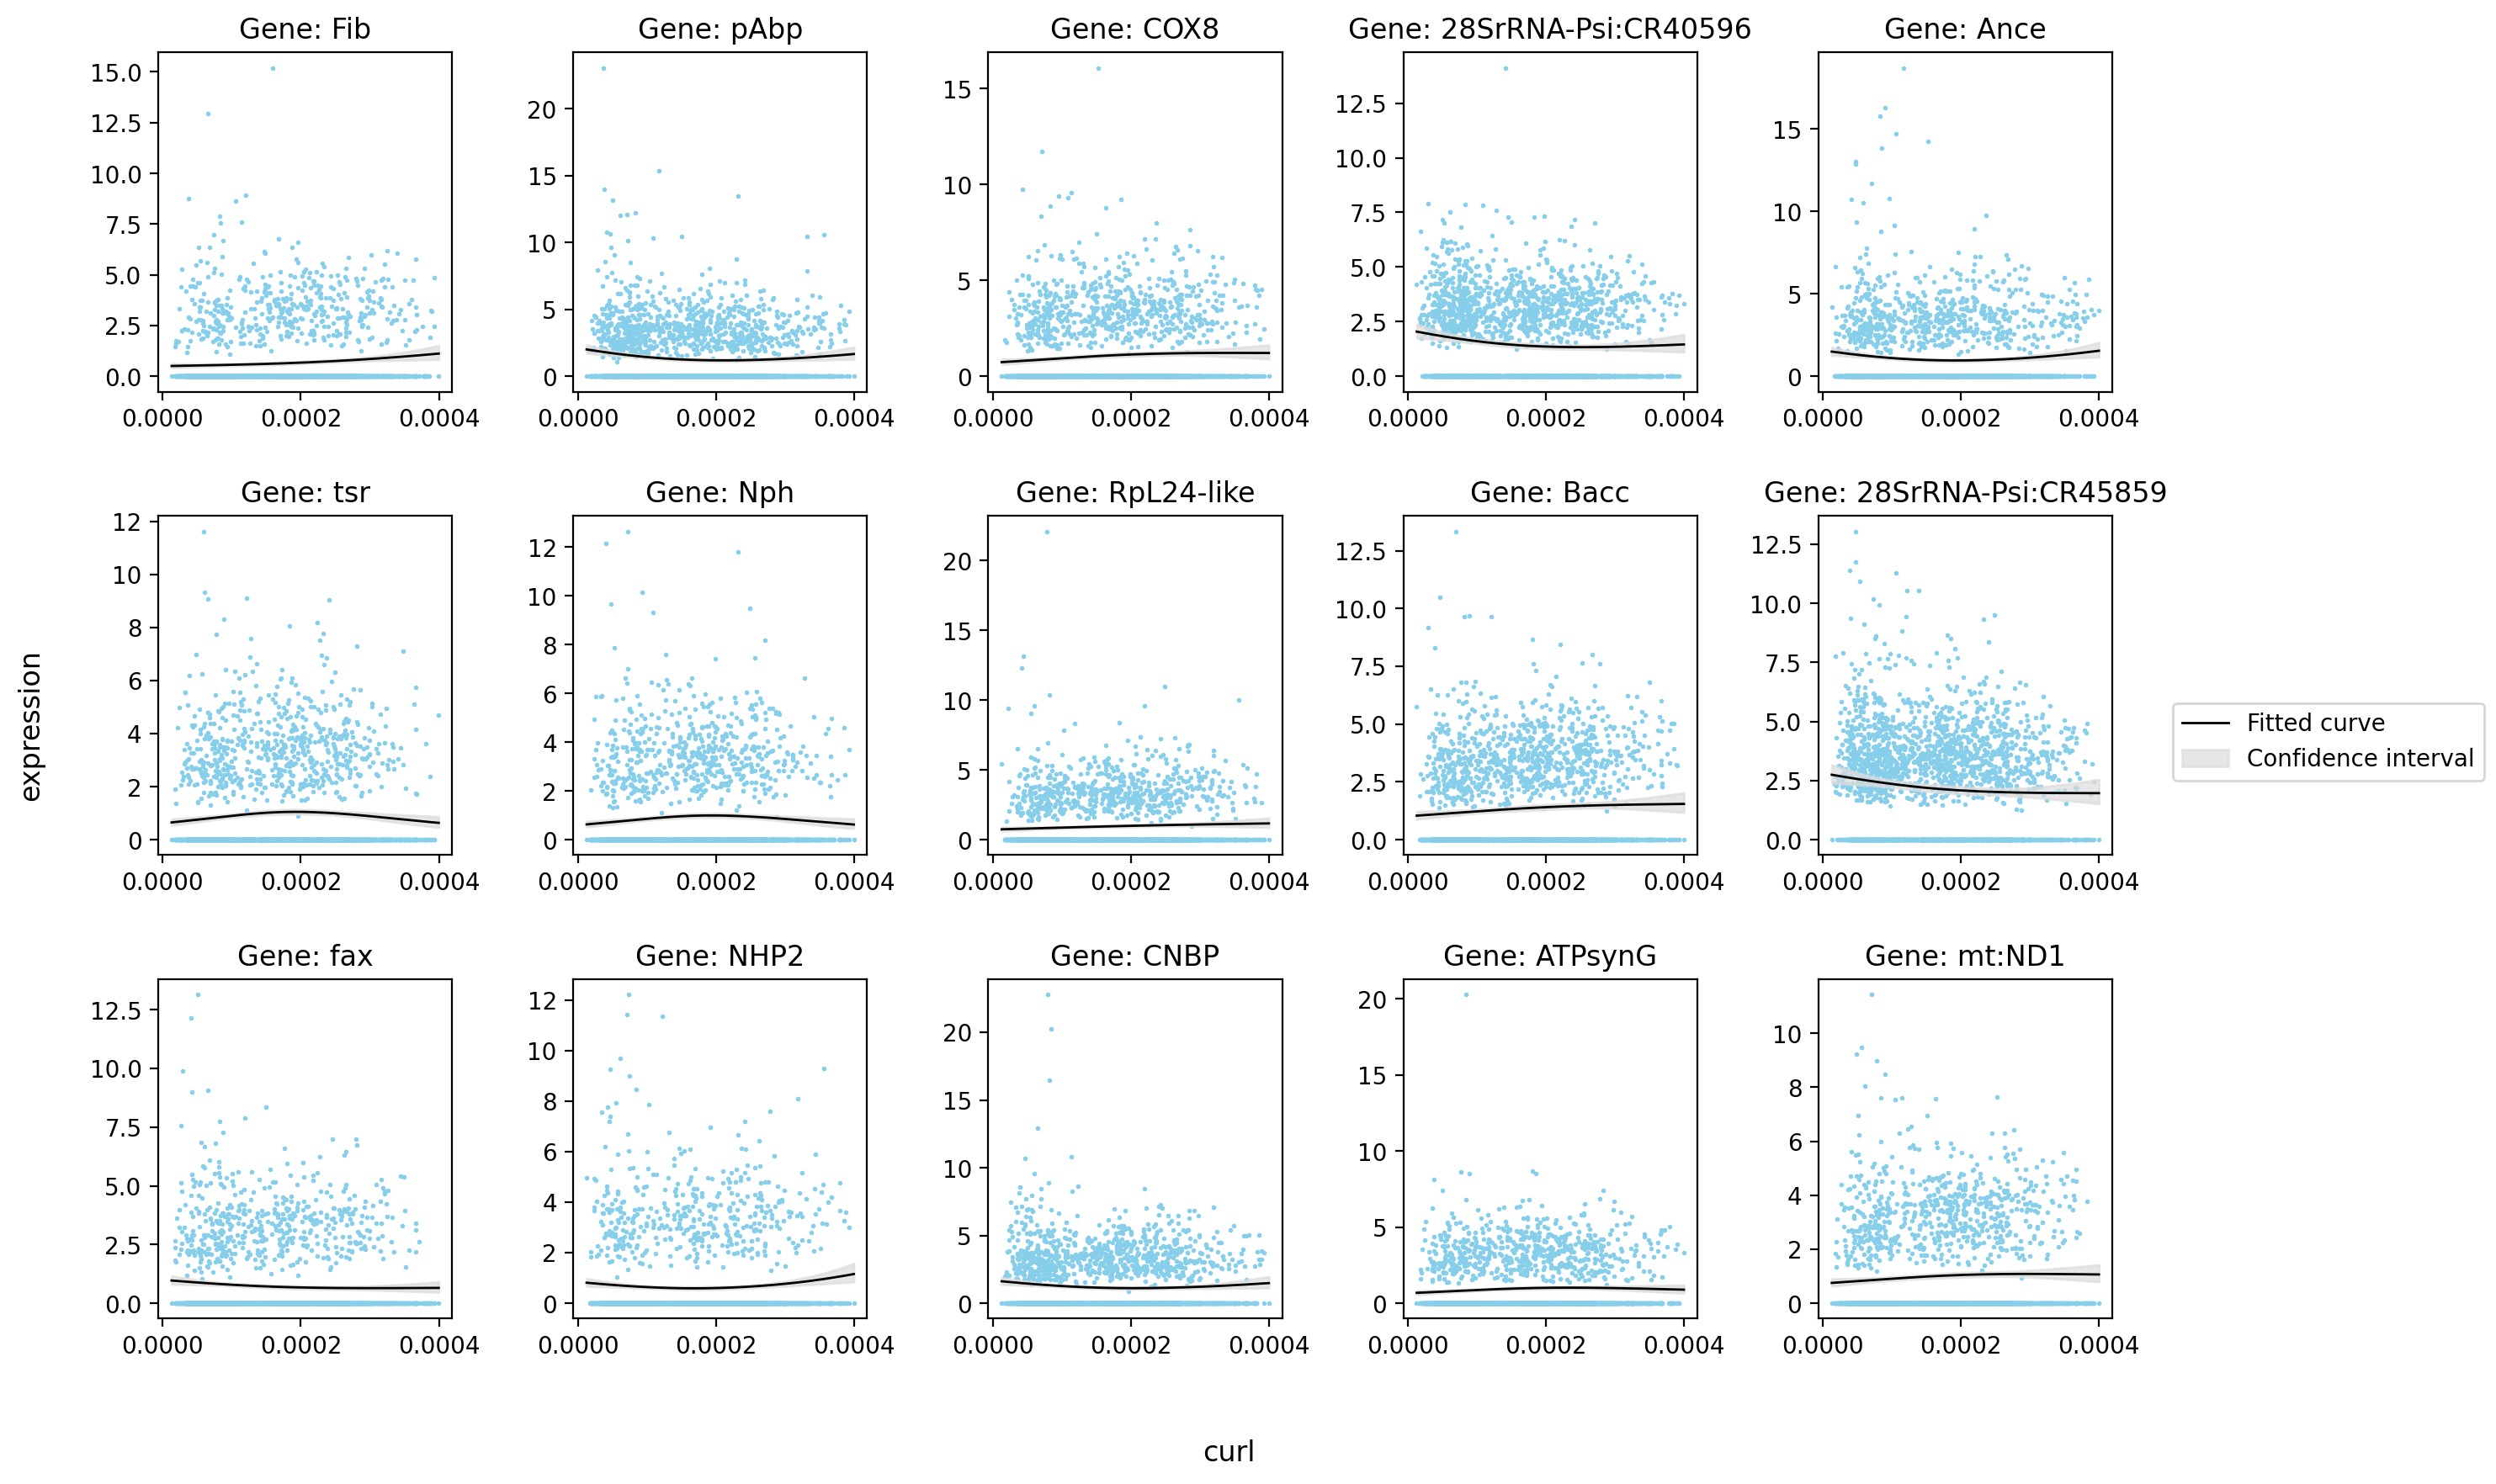

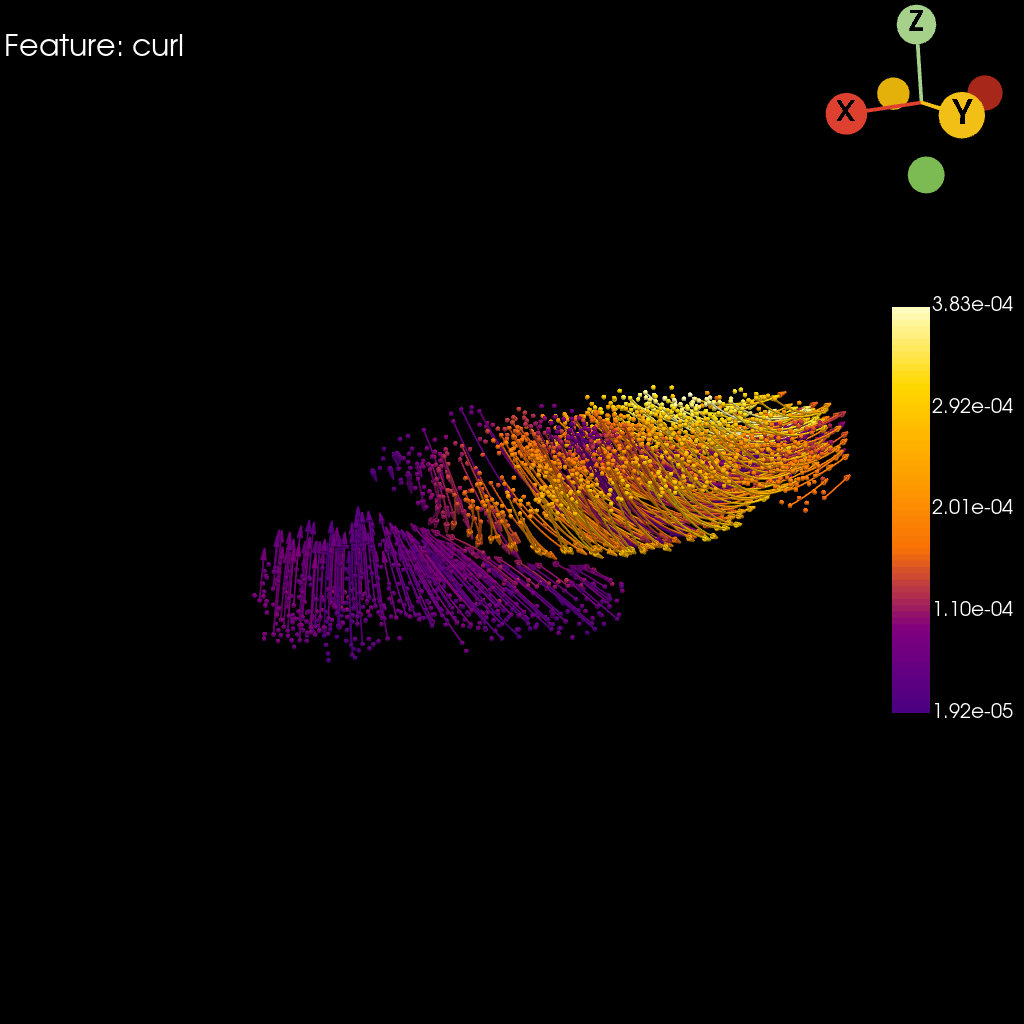

In [14]:
st.pl.glm_fit(
    adata=stage_adata,
    gene=glm_data.index.tolist(),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    lowess=False,
    frac=0.2,
    save_show_or_return="both",
)
st.pl.curl(
    adata=stage_adata,
    model=st.tdr.collect_models([stage_pc, trajectory_model]),
    curl_key=key,
    colormap="default_cmap",
    jupyter="static",
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    cpo=cpo,
    window_size=(1024, 1024),
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
)

In [15]:
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added=key,
    labels=np.asarray(stage_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[key]),
    where="point_data",
    inplace=True,
)
cells_linear_models = st.tdr.construct_genesis_X(
    stages_X=[stage_adata.obsm["3d_align_spatial"], stage_adata.obsm["X_cells_mapping"]],
    n_spacing=100-1,
    key_added=key,
    label=[np.asarray(stage_adata.obs[key])] * 100,
)
st.pl.three_d_animate(
     models=cells_linear_models,
    stable_model=trajectory_model,
    key=key,
    stable_kwargs=dict(
        key=key,
        model_style="wireframe",
        model_size=2,
        ambient=0.5,
        opacity=0.3,
        colormap="default_cmap",
        show_legend=False,
    ),
    filename=f"E7-9h_midgut_{key}_linear_movie_with_trajectory.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)
st.pl.three_d_animate(
    models=cells_linear_models,
    stable_model=None,
    key=key,
    filename=f"E7-9h_midgut_{key}_linear_movie.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)

### Torsion

In [16]:
key = "torsion"
glm_key = f"glm_degs_{key}"

st.tdr.morphofield_torsion(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
st.tl.glm_degs(adata=stage_adata, layer=None, fullModelFormulaStr=f'~cr({key}, df=3)', key_added=glm_key, qval_threshold=0.01, llf_threshold=-2500)
glm_data = stage_adata.uns[glm_key]["glm_result"]
glm_dict[key] = glm_data
glm_data

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.0342s]


Calculating torsion: 100%|██████████| 2326/2326 [00:00<00:00, 123461.80it/s]

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.


|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [332.7657s]


status family  log-likelihood          pval          qval
28SrRNA-Psi:CR45862     ok    NB2    -4346.507812  3.861141e-15  2.472739e-12
awd                     ok    NB2    -3186.442383  3.803082e-07  1.154048e-05
COX5B                   ok    NB2    -2744.803711  2.241822e-06  4.618874e-05
COX8                    ok    NB2    -3231.869873  5.392043e-06  9.460696e-05
28SrRNA-Psi:CR45859     ok    NB2    -4634.142578  1.133787e-05  1.689693e-04
bnb                     ok    NB2    -2515.703857  1.134524e-05  1.689693e-04
Cyp1                    ok    NB2    -3642.751221  5.894959e-05  6.097518e-04
COX5A                   ok    NB2    -2502.031494  6.766557e-05  6.806412e-04
COX7C                   ok    NB2    -2909.620850  2.804796e-04  2.050890e-03
mt:lrRNA                ok    NB2    -6082.588867  4.755917e-04  3.090644e-03
Df31                    ok    NB2    -3453.745605  5.343023e-04  3.363636e-03
Ance                    ok    NB2    -3360.501221  5.547805e-04  3.470894e-03
eEF1beta                ok    NB2    -3307.284668  6.429467e-04  3.881419e-03
CG11267                 ok    NB2    -2541.744141  8.072325e-04  4.622639e-03

Saving figure to develop/develop_midgut/genesis_feature/E7-9h_midgut_torsion/E7-9h_midgut_glm_degs_fit_torsion.pdf...
Done


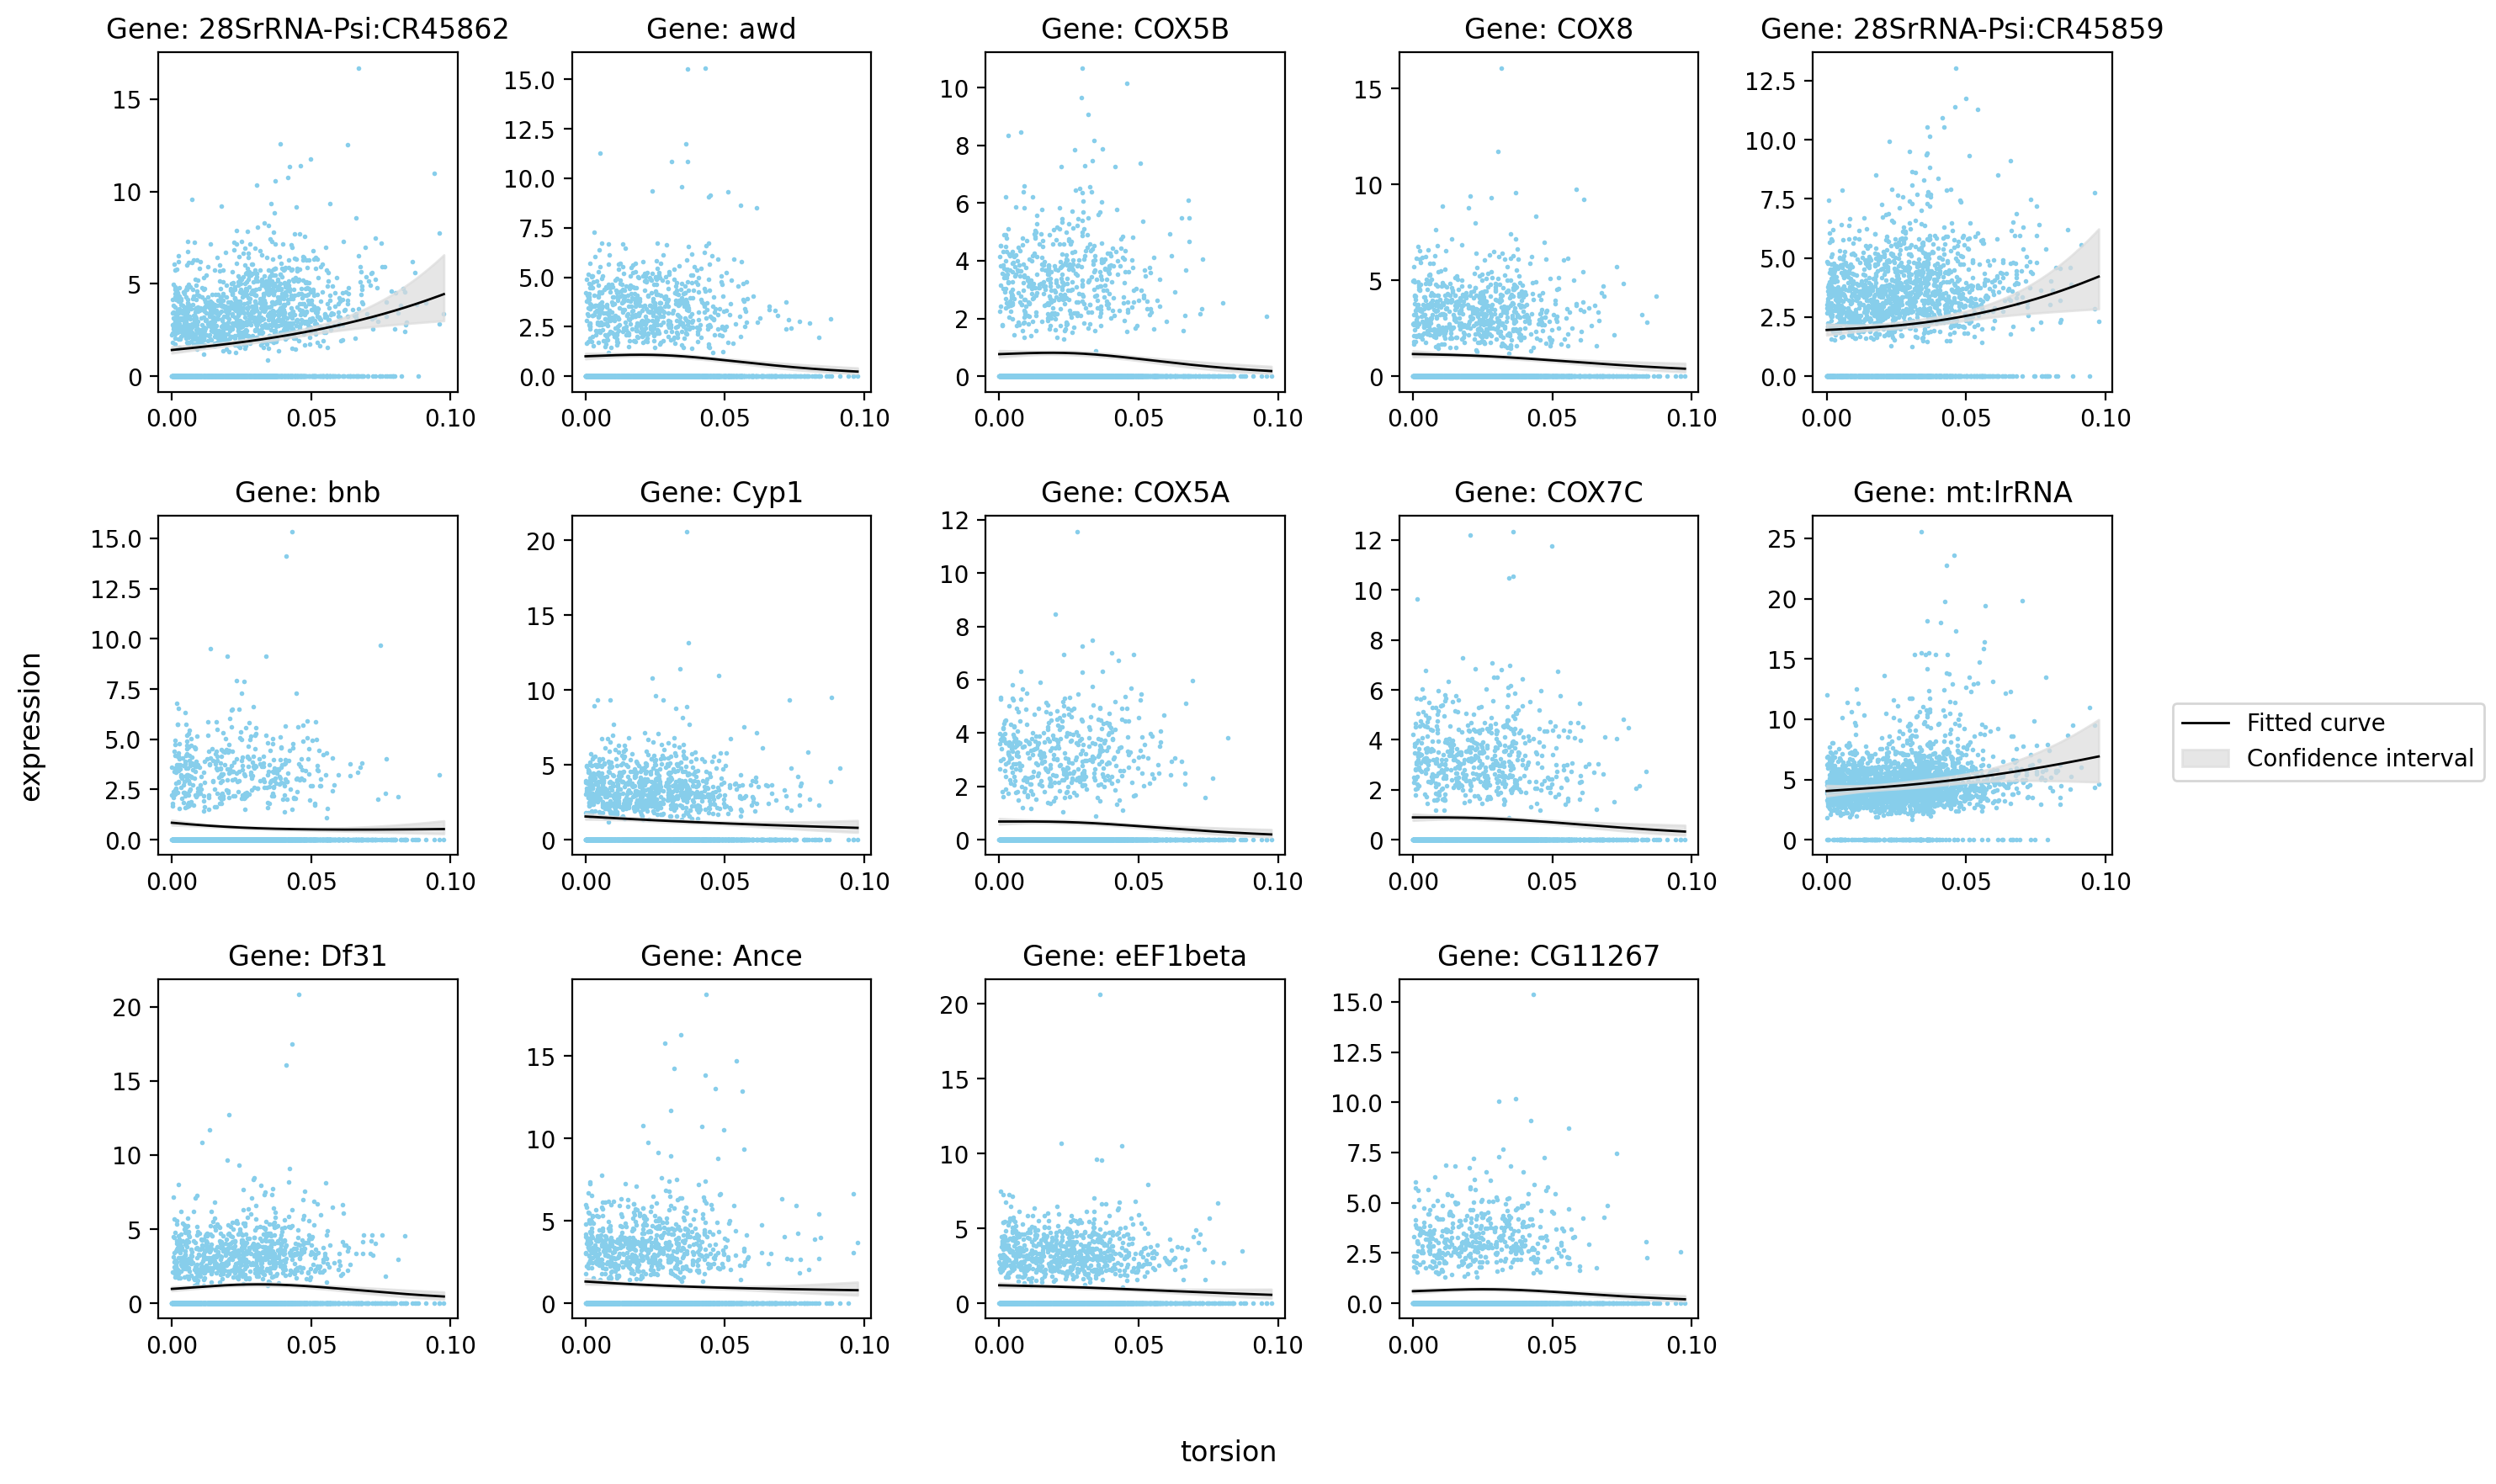

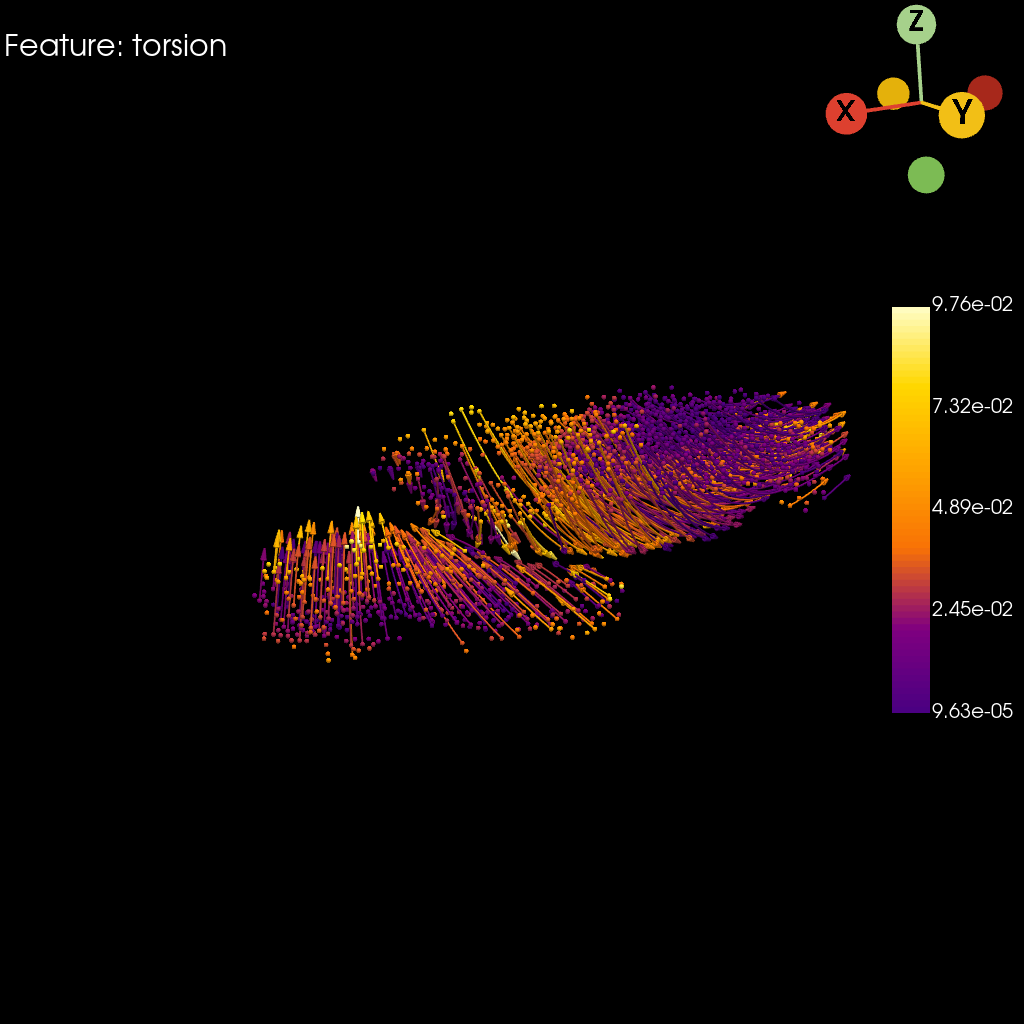

In [17]:
st.pl.glm_fit(
    adata=stage_adata,
    gene=glm_data.index.tolist(),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    feature_fit="mu",
    glm_key=glm_key,
    lowess=False,
    frac=0.2,
    save_show_or_return="both",
)
st.pl.torsion(
    adata=stage_adata,
    model=st.tdr.collect_models([stage_pc, trajectory_model]),
    torsion_key=key,
    colormap="default_cmap",
    jupyter="static",
    model_style=["points", "wireframe"],
    model_size=[5, 2],
    cpo=cpo,
    window_size=(1024, 1024),
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
)

In [18]:
st.tdr.add_model_labels(
    model=trajectory_model,
    key_added=key,
    labels=np.asarray(stage_adata[np.asarray(trajectory_model.point_data["obs_index"])].obs[key]),
    where="point_data",
    inplace=True,
)
cells_linear_models = st.tdr.construct_genesis_X(
    stages_X=[stage_adata.obsm["3d_align_spatial"], stage_adata.obsm["X_cells_mapping"]],
    n_spacing=100-1,
    key_added=key,
    label=[np.asarray(stage_adata.obs[key])] * 100,
)
st.pl.three_d_animate(
     models=cells_linear_models,
    stable_model=trajectory_model,
    key=key,
    stable_kwargs=dict(
        key=key,
        model_style="wireframe",
        model_size=2,
        ambient=0.5,
        opacity=0.3,
        colormap="default_cmap",
        show_legend=False,
    ),
    filename=f"E7-9h_midgut_{key}_linear_movie_with_trajectory.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)
st.pl.three_d_animate(
    models=cells_linear_models,
    stable_model=None,
    key=key,
    filename=f"E7-9h_midgut_{key}_linear_movie.mp4",
    model_style="points",
    model_size=5,
    ambient=0.5,
    colormap="default_cmap",
    show_legend=True,
    legend_kwargs=dict(title="", fmt="%.2e", legend_loc=(0.87, 0.3), label_font_size=20),
    off_screen=True,
    jupyter=False,
    background="black",
    cpo=cpo,
    window_size=(1024, 1024),
)

### Jacobian

In [19]:
key = "jacobian"
st.tdr.morphofield_jacobian(adata=stage_adata, vf_key="VecFld_morpho", key_added=key,)
stage_adata.uns["jacobian"]

array([[[ 2.08105242e-05,  2.70779418e-05,  3.14283350e-05, ...,
         -8.25586263e-06, -8.49332510e-06, -5.65412876e-06],
        [ 7.23267922e-05,  6.98323637e-05,  6.34322214e-05, ...,
          3.69536432e-07,  2.37314756e-07, -9.78666713e-07],
        [ 4.65323612e-05,  4.93631551e-05,  3.55578438e-05, ...,
         -3.28196112e-06, -3.21871336e-06, -5.28409549e-06]],

       [[ 1.67115495e-06,  7.37013386e-06,  1.69219829e-05, ...,
          7.19850134e-06,  7.21621752e-06,  2.70224705e-06],
        [ 5.42722509e-05,  5.09177864e-05,  5.47200113e-05, ...,
         -7.52587956e-06, -8.50232404e-06, -6.79560366e-06],
        [ 4.87511113e-05,  5.29128280e-05,  4.34329063e-05, ...,
          9.67988261e-07,  3.44231301e-08,  3.61775236e-06]],

       [[ 7.83754913e-06,  1.73498770e-05,  3.04055759e-05, ...,
          7.92778250e-06,  6.45248208e-06, -1.02374499e-05],
        [ 1.02038938e-04,  1.00946200e-04,  9.68161684e-05, ...,
          1.84122214e-05,  1.03350391e-05,  1.363

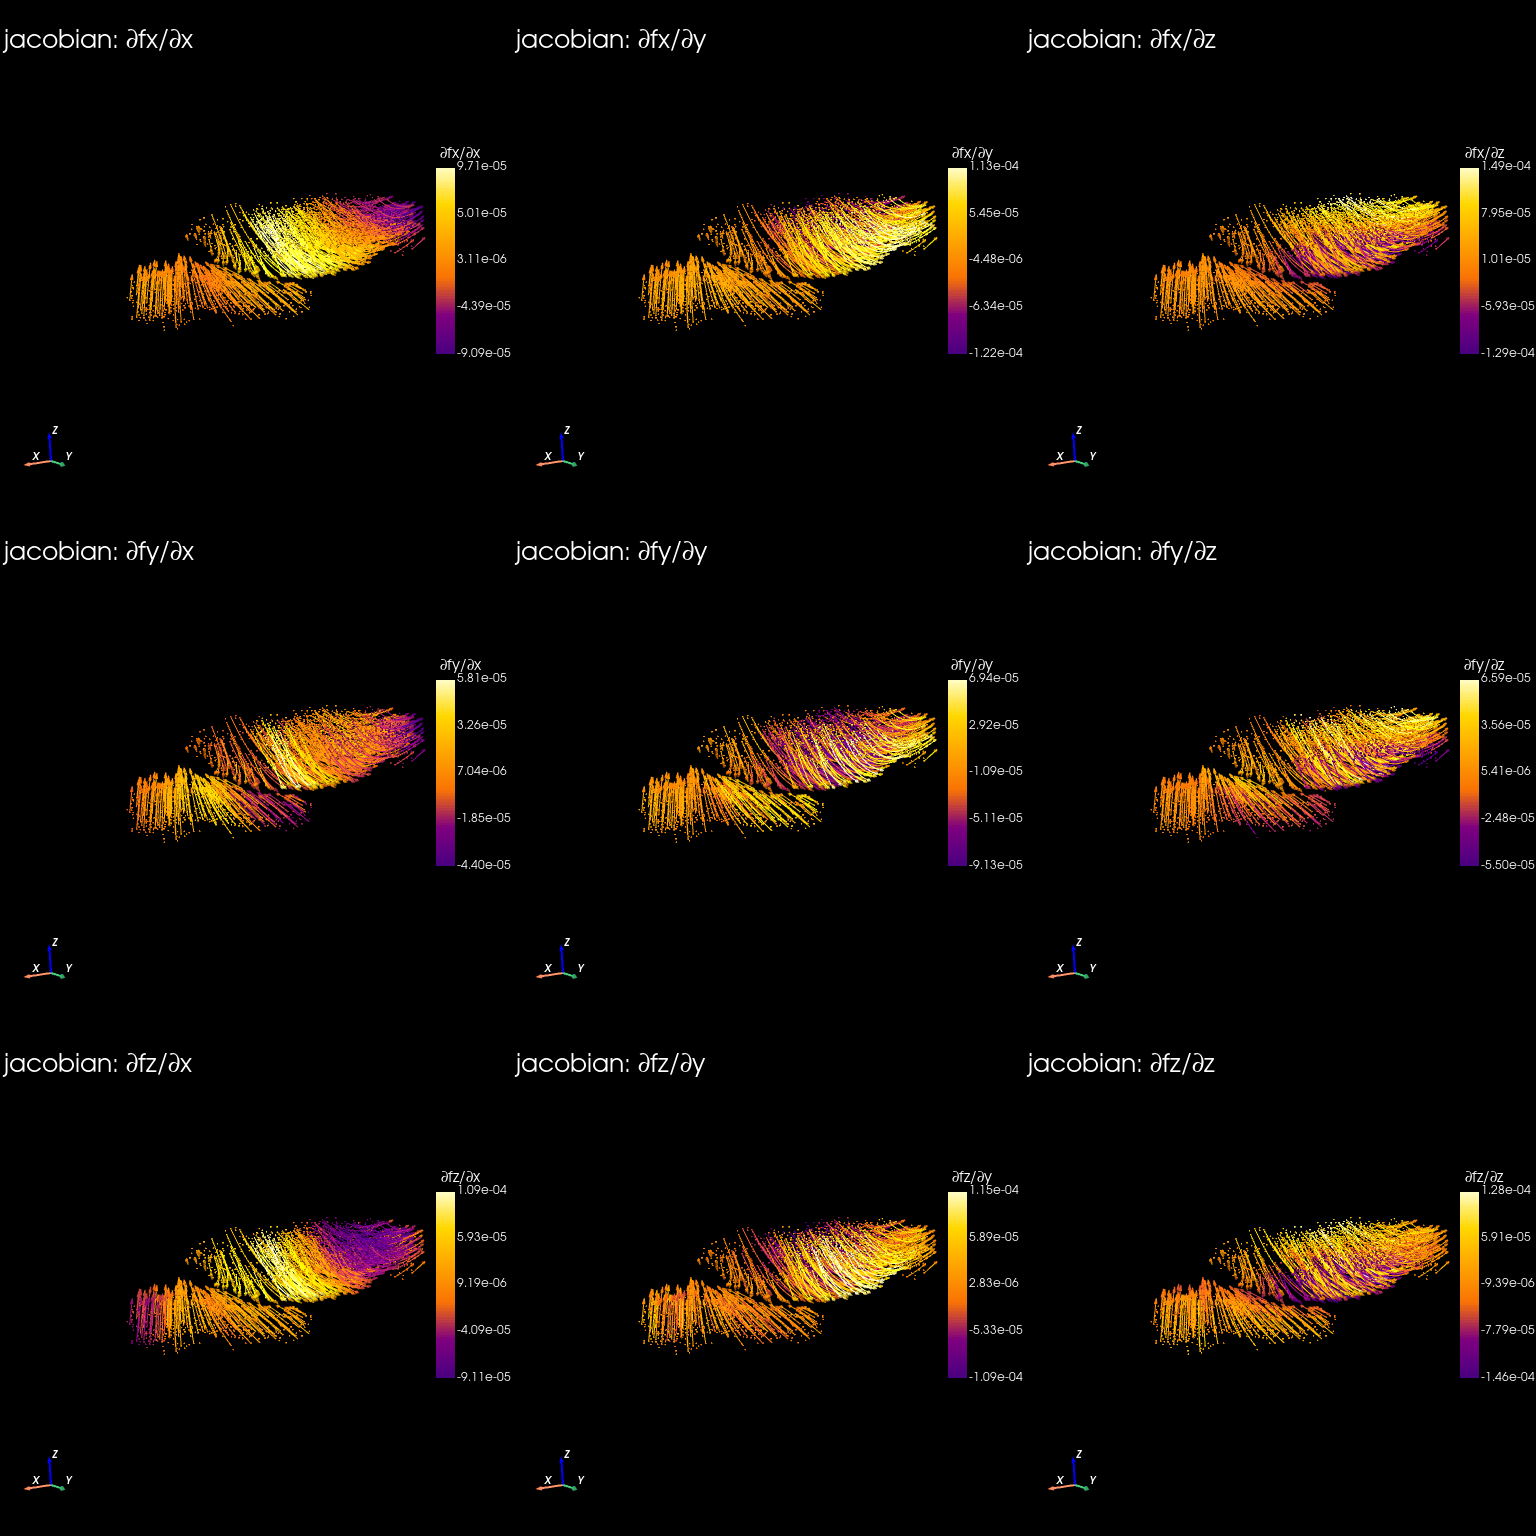

In [20]:
st.pl.jacobian(
    adata=stage_adata,
    model=st.tdr.collect_models([stage_pc, trajectory_model]),
    jacobian_key="jacobian",
    colormap="default_cmap",
    jupyter="static",
    model_style=["points", "wireframe"],
    model_size=[2.5, 1],
    cpo=[cpo],
    window_size=(512*3, 512*3),
)

## GO analysis

In [21]:
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [22]:
for key, data in glm_dict.items():
    if len(data.index.tolist()) > 0:
        save_folder = f"E7-9h_midgut_{key}"

        # GO-biologial process
        go_bp = gp.enrichr(
            gene_list=data.index.tolist(),
            gene_sets="GO_Biological_Process_2018",
            organism="fly",
            outdir=save_folder,
            no_plot=True,
            verbose=True
        )
        # GO-cellular component
        gp_cc = gp.enrichr(
            gene_list=data.index.tolist(),
            gene_sets="GO_Cellular_Component_2018",
            organism="fly",
            outdir=save_folder,
            no_plot=True,
            verbose=True
        )
        # GO-molecular function
        go_mf = gp.enrichr(
            gene_list=data.index.tolist(),
            gene_sets="GO_Molecular_Function_2018",
            organism="fly",
            outdir=save_folder,
            no_plot=True,
            verbose=True
        )

2022-10-16 14:11:43,473 Connecting to Enrichr Server to get latest library names
2022-10-16 14:11:44,859 Analysis name: , Enrichr Library: GO_Biological_Process_2018
2022-10-16 14:11:51,166 Save file of enrichment results: Job Id:231b5ebbe467f630d7a0ea9e7a9a39bd
2022-10-16 14:11:51,170 Done.

2022-10-16 14:11:51,171 Connecting to Enrichr Server to get latest library names
2022-10-16 14:11:52,551 Analysis name: , Enrichr Library: GO_Cellular_Component_2018
2022-10-16 14:11:56,542 Save file of enrichment results: Job Id:e5d4d3bb96e241ee70e016b34a31fc08
2022-10-16 14:11:56,546 Done.

2022-10-16 14:11:56,547 Connecting to Enrichr Server to get latest library names
2022-10-16 14:11:57,954 Analysis name: , Enrichr Library: GO_Molecular_Function_2018
2022-10-16 14:12:01,850 Save file of enrichment results: Job Id:44c1a53e9556e824aef5ea46234a3cd6
2022-10-16 14:12:01,852 Done.

2022-10-16 14:12:01,853 Connecting to Enrichr Server to get latest library names
2022-10-16 14:12:03,349 Analysis name

## Genes expression pattern

In [23]:
gene_list = list(set([gene for data in glm_dict.values() for gene in data.index.tolist()]))

In [24]:
for gene in gene_list:
    obs_index = stage_pc.point_data["obs_index"].tolist()
    mkg_exp = stage_adata[obs_index, gene].X.flatten().astype(np.float64)
    st.tdr.add_model_labels(model=stage_pc, labels=mkg_exp, key_added=gene, where="point_data", inplace=True)

    mkg_amap = mkg_exp.copy()
    mkg_amap = mkg_amap / mkg_amap.max()
    mkg_amap[mkg_amap <= 0.5] = 0.5

    rename_gene = str(gene).replace(":", "-") if ":" in gene else gene
    st.pl.three_d_plot(
        model=stage_pc,
        key=gene,
        model_style="points",
        model_size=5,
        # opacity=mkg_amap,
        ambient=0.5,
        colormap="default_cmap",
        text=f"\nGene: {gene}",
        show_legend=True,
        legend_kwargs=dict(title=""),
        off_screen=True,
        jupyter=False,
        background="black",
        cpo=cpo,
        window_size=(1024, 1024),
        filename=f"pc_model_gene_{rename_gene}.pdf"
    )